We show here how to train the Rhapsody random forest classifier in its final form.

Based on the analyses illustrated in the `RF_optimization` notebook, we will make the following choices:
* the training dataset will only contain SAVs with at least 1 review star in the ClinVar database (when available) and with same clinical interpretation in all 7 datasets
* only PDB structures with at least 150 residues will be considered
* the random forest classifier hyperparameters are set based on the optimization procedure (max. number of features = 2, number of trees in the forest = 1500)
* dynamical features are computed from ANM without environmental effects (`chain` model)

## Importing the training dataset

In [1]:
import sys, os
import pickle
import numpy as np
from glob import glob
from prody import LOGGER

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.family': 'Arial'})
%matplotlib inline

In [3]:
# please make sure to extract the data folder beforehand
ID = np.load('../1-Training_Dataset/local/data/precomputed_features-ID.npy')
len(ID)

91697

In [4]:
# let's discard SAVs with unknown significance (true_label == -1), ...
ID = ID[ID['true_label'] != -1]
len(ID)

87726

In [5]:
# ... SAVs with associated PDB structure smaller than 150 residues ...
ID = ID[ ID['PDB_length' ] >= 150]
len(ID)

23085

In [6]:
# ... and SAVs with 0 review star according to ClinVar
ID_SAVs_info = np.load('../1-Training_Dataset/local/data/Integrated_Dataset-SAVs.npy')
ClinVar_review_stars = {s['SAV_coords']: s['ClinVar_review_star'] for s in ID_SAVs_info}

ID = ID[ [ClinVar_review_stars[SAV] != 0 for SAV in ID['SAV_coords']] ]
len(ID)

20361

In [7]:
# fraction of positives (dataset bias):
sum(ID['true_label']) / len(ID)

0.6692205687343451

In [8]:
# number of unique chains from PDB structures
len(set([' '.join(PDB_coords.split()[:2]) for PDB_coords in ID['Uniprot2PDB']]))

2828

A copy of this optimized dataset can be found in `../1-Training_Dataset/local/data/precomputed_features-ID_opt.npy`

## Training of Random Forest classifier

In [9]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rd

In [10]:
if not os.path.isdir('local'):
    os.mkdir('local')
if not os.path.isdir('local/results'):
    os.mkdir('local/results')

Let's train 3 classifiers based on 3 different set of features. We will also evaluate them individually through 10-fold cross-validation, with and without residue- or protein-stratification.

In [11]:
if os.path.isfile('local/results/RF_training_summaries.pkl'):
    RF_training_summaries = pickle.load(open('local/results/RF_training_summaries.pkl', 'rb'))
    print('A pickle containing precomputed results has been found. \n'
          'Please delete it if you wish to run the analysis again. \n'
          'Log saved in local/results/RF_training.log \n')
    ! head -25 local/results/RF_training.log; echo '...'
else:
    LOGGER.start('local/results/RF_training.log')
    RF_training_summaries = {}

    for version in ['full', 'reduced', 'EVmut']:
        
        sel = ['SAV_coords', 'true_label'] + rd.DEFAULT_FEATSETS[version]
        ID_subset = ID[sel]

        LOGGER.info(f'VERSION: {version}')

        # create folder
        folder = f'local/results/RF_training-{version}'
        os.mkdir(folder)

        # run training procedure
        train_output = rd.trainRFclassifier(ID_subset)
        for file in glob('*png') + ['trained_classifier.pkl',]:
            os.rename(file, os.path.join(folder, file))
        
        # cross-validation with residue-stratification
        LOGGER.info('')
        LOGGER.info('Residue-stratified cross-validation:')
        CV_res = rd.RandomForestCV(ID_subset, stratification='residue')
        for file in glob('*png'):
            new_fname = file.replace('.png', '-res_strat.png')
            os.rename(file, os.path.join(folder, new_fname))
        
        # cross-validation with protein-stratification
        LOGGER.info('')
        LOGGER.info('Protein-stratified cross-validation:')
        CV_prot = rd.RandomForestCV(ID_subset, stratification='protein')
        for file in glob('*png'):
            new_fname = file.replace('.png', '-prot_strat.png')
            os.rename(file, os.path.join(folder, new_fname))
        
        RF_training_summaries[version] = {
            'no stratification': train_output['CV summary'],
            'residue-stratification': CV_res,
            'protein-stratification': CV_prot
        }      

        LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(RF_training_summaries, open('local/results/RF_training_summaries.pkl', 'wb'))

    LOGGER.close('local/results/RF_training.log')

A pickle containing precomputed results has been found. 
Please delete it if you wish to run the analysis again. 
Log saved in local/results/RF_training.log 

Logging started at 2019-10-20 17:52:08.586682
VERSION: full
3918 out of 20361 cases ignored with missing features.
CV iteration # 1:   AUROC = 0.856   AUPRC = 0.920   OOB score = 0.811
CV iteration # 2:   AUROC = 0.863   AUPRC = 0.927   OOB score = 0.811
CV iteration # 3:   AUROC = 0.849   AUPRC = 0.914   OOB score = 0.811
CV iteration # 4:   AUROC = 0.863   AUPRC = 0.924   OOB score = 0.809
CV iteration # 5:   AUROC = 0.854   AUPRC = 0.924   OOB score = 0.813
CV iteration # 6:   AUROC = 0.861   AUPRC = 0.926   OOB score = 0.810
CV iteration # 7:   AUROC = 0.856   AUPRC = 0.922   OOB score = 0.810
CV iteration # 8:   AUROC = 0.856   AUPRC = 0.924   OOB score = 0.811
CV iteration # 9:   AUROC = 0.847   AUPRC = 0.912   OOB score = 0.812
CV iteration #10:   AUROC = 0.866   AUPRC = 0.925   OOB score = 0.809
--------------------------

**NB:** the dataset folds generated during cross-validation are included in the output summary, which is also stored in the pickle containing the trained classifier:

In [12]:
RF_training_summaries['full']['no stratification']['folds']

[[array([    0,     1,     2, ..., 16439, 16440, 16441]),
  array([    7,     9,    34, ..., 16408, 16409, 16442])],
 [array([    0,     1,     2, ..., 16440, 16441, 16442]),
  array([    5,    28,    38, ..., 16424, 16427, 16438])],
 [array([    0,     1,     3, ..., 16440, 16441, 16442]),
  array([    2,     6,    14, ..., 16404, 16417, 16429])],
 [array([    0,     2,     3, ..., 16439, 16440, 16442]),
  array([    1,    21,    36, ..., 16433, 16436, 16441])],
 [array([    0,     1,     2, ..., 16440, 16441, 16442]),
  array([   13,    46,    56, ..., 16405, 16416, 16439])],
 [array([    1,     2,     3, ..., 16440, 16441, 16442]),
  array([    0,    27,    37, ..., 16414, 16426, 16431])],
 [array([    0,     1,     2, ..., 16440, 16441, 16442]),
  array([    3,    10,    15, ..., 16399, 16406, 16419])],
 [array([    0,     1,     2, ..., 16440, 16441, 16442]),
  array([   29,    39,    42, ..., 16430, 16432, 16437])],
 [array([    0,     1,     2, ..., 16440, 16441, 16442]),
  arra

## Comparison with PolyPhen-2 and EVmutation

Let's recover a NumPy array containing predictions from PolyPhen-2:

In [13]:
pph2_predictions = np.load('../1-Training_Dataset/local/data/PolyPhen2_predictions-ID.npy')
pph2_predictions.dtype

dtype([('SAV_coords', '<U25'), ('prediction', '<U25'), ('pph2_class', '<U25'), ('pph2_prob', '<f4')])

In [14]:
# We select the same subset of the Integrated Dataset as the one used for Rhapsody
pph2_predictions = pph2_predictions[
    [SAV in ID['SAV_coords'] for SAV in pph2_predictions['SAV_coords']] ]

# NB: the two arrays should be sorted in the same way
assert all(pph2_predictions['SAV_coords'] == ID['SAV_coords'])

In [15]:
PP2_score = pph2_predictions['pph2_prob']
PP2_class = pph2_predictions['pph2_class']
PP2_class[:5]

array(['neutral', 'neutral', 'neutral', 'neutral', 'deleterious'],
      dtype='<U25')

EVmutation only provides a score ($\Delta E$), that anti-correlates with a variant's pathogenicity. The Rhapsody package includes a function for translating this score into pathogenicity classes, based on a precomputed optimized cutoff $\Delta E_{\textrm{cut}}$.

In [16]:
EVmut_score = - ID['EVmut-DeltaE_epist']
EVmut_class = rd.EVmutation.calcEVmutPathClasses(ID['EVmut-DeltaE_epist'])
EVmut_class[:5]

array(['?', '?', '?', 'neutral', 'deleterious'], dtype='<U11')

We can now compute for PolyPhen-2 and EVmutation's predictions the same metrics as for Rhapsody's. Note that some predictions might be missing.

In [17]:
PP2_EVm_metrics = {}

for method, score, classes in [('PolyPhen-2', PP2_score, PP2_class),
                               ('EVmutation', EVmut_score, EVmut_class)]:
    # select valid predictions
    sel = ~np.isnan(score)
    true_labels = ID['true_label'][sel]
    score = score[sel]
    # convert classes to binary labels
    classes = np.where(classes[sel] == 'deleterious', 1, 0)
    
    PP2_EVm_metrics[method] = {
        'dataset size': sum(sel),
        **rd.calcScoreMetrics(true_labels, score),
        **rd.calcClassMetrics(true_labels, classes)
    }

In [18]:
if not os.path.isdir('local/figures'):
    os.mkdir('local/figures')

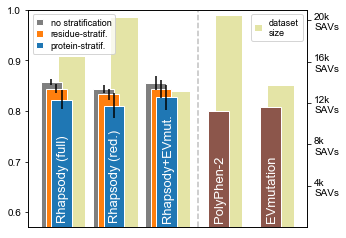

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax2 = ax.twinx()

d = RF_training_summaries
opts = {'width': .4, 'edgecolor': 'w'}

y = {}
yerr = {}
for s in ['no stratification', 'residue-stratification', 'protein-stratification']:
    y[s] = [d[v][s]['mean AUROC'][0] for v in ['full', 'reduced', 'EVmut']]
    yerr[s] = [d[v][s]['mean AUROC'][1] for v in ['full', 'reduced', 'EVmut']]

# left bars - Rhapsody
x = np.arange(3)
h0 = ax.bar(x+.0, y['no stratification'], yerr=yerr['no stratification'],
            color='C7', **opts, label='no stratification')
h1 = ax.bar(x+.1, y['residue-stratification'], yerr=yerr['residue-stratification'],
            color='C1', **opts, label='residue-stratif.')
h2 = ax.bar(x+.2, y['protein-stratification'], yerr=yerr['protein-stratification'],
            color='C0', **opts, label='protein-stratif.')

# right bars - PolyPhen-2 and EVmutation
x = np.array([3, 4])
y = [PP2_EVm_metrics[m]['AUROC'] for m in ['PolyPhen-2', 'EVmutation']]
ax.bar(x+.2, y, color='C5', **opts)

# background - dataset size
x = np.arange(5)
y = [d[v]['no stratification']['dataset size'] for v in ['full', 'reduced', 'EVmut']]
y.append(PP2_EVm_metrics['PolyPhen-2']['dataset size'])
y.append(PP2_EVm_metrics['EVmutation']['dataset size'])
ax2.bar(x+0.4, y, color='C8', width=.5, alpha=0.4, label='dataset\nsize')
ax2.set_zorder(ax.get_zorder()-1)
ax.patch.set_visible(False)

# legend
handles = [h0, h1, h2]
ax.legend(handles, [h.get_label() for h in handles], handlelength=.8, fontsize=9, 
          loc='upper left', labelspacing=.3)
ax2.legend(handlelength=.8, fontsize=9, loc='upper right', labelspacing=.3)

# bar labels
labels = ['Rhapsody (full)', 'Rhapsody (red.)', 'Rhapsody+EVmut.',
          'PolyPhen-2', 'EVmutation']
x = np.arange(5)
for i,s in enumerate(labels):
    ax.text(x[i]+.105, 0.58, s, color='w', rotation=90, va='bottom', size='13')

ax.axvline(x=2.8, color='gray', ls='--', alpha=.5)
    
ax.set_ylim((.57, 1))
ax.set_yticks(np.arange(5)*.1 + .6)
ax.set_xticks([])
ax2.set_ylim((0, 21000))
ax2.set_yticks(range(4000, 21000, 4000))
ax2.set_yticklabels(['4k\nSAVs', '8k\nSAVs', '12k\nSAVs', '16k\nSAVs', '20k\nSAVs'])

fig.savefig('local/figures/Rhapsody_vs_PP2_EVmut.png', dpi=300);

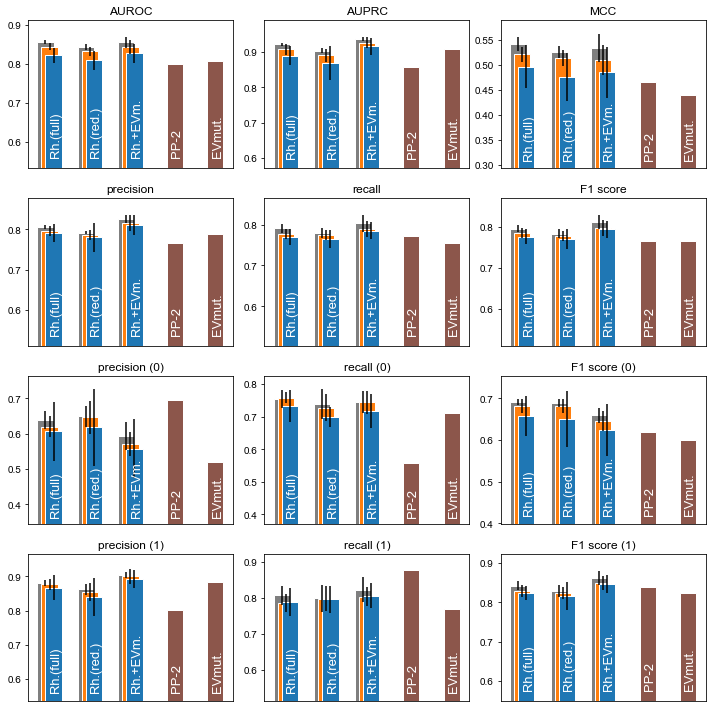

In [20]:
stats = ['AUROC', 'AUPRC', 'MCC', 'precision', 'recall', 'F1 score',
         'precision (0)', 'recall (0)', 'F1 score (0)', 
         'precision (1)', 'recall (1)', 'F1 score (1)']

fig, axes = plt.subplots(4, 3, figsize=(10, 10))

d = RF_training_summaries
opts = {'width': .4, 'edgecolor': 'w'}

for i, stat in enumerate(stats):
    
    ax = axes[int(i/3), i%3]
    ax.set_title(stat)

    y = {}
    yerr = {}
    for s in ['no stratification', 'residue-stratification', 'protein-stratification']:
        y[s] = [d[v][s][f'mean {stat}'][0] for v in ['full', 'reduced', 'EVmut']]
        yerr[s] = [d[v][s][f'mean {stat}'][1] for v in ['full', 'reduced', 'EVmut']]

    # left bars - Rhapsody
    x = np.arange(3)
    h0 = ax.bar(x+.0, y['no stratification'], yerr=yerr['no stratification'],
                color='C7', **opts, label='no stratification')
    h1 = ax.bar(x+.1, y['residue-stratification'], yerr=yerr['residue-stratification'],
                color='C1', **opts, label='residue-stratif.')
    h2 = ax.bar(x+.2, y['protein-stratification'], yerr=yerr['protein-stratification'],
                color='C0', **opts, label='protein-stratif.')

    # right bars - PolyPhen-2 and EVmutation
    x = np.array([3, 4])
    y = [PP2_EVm_metrics[m][stat] for m in ['PolyPhen-2', 'EVmutation']]
    ax.bar(x+.2, y, color='C5', **opts)

    y_min = min(y)*2/3
    ax.set_ylim(bottom=y_min)
    
    # bar labels
    labels = ['Rh.(full)', 'Rh.(red.)', 'Rh.+EVm.', 'PP-2', 'EVmut.']
    x = np.arange(5)
    for i,s in enumerate(labels):
        ax.text(x[i]+.105, y_min*1.05, s, color='w', rotation=90, va='bottom', size='13')

    ax.set_xticks([])
    
fig.tight_layout()
fig.savefig('local/figures/Rhapsody_vs_PP2_EVmut-2.png', dpi=300);

## Feature importances

We can assess the relative importance of each feature by looking at their weights in the random forest.

In [21]:
abbrv = {
    'ANM_MSF-chain': 'ANM-MSF',
    'ANM_effectiveness-chain': 'ANM-effect.',
    'ANM_sensitivity-chain': 'ANM-sens.',
    'BLOSUM': 'BLOSUM',
    'Delta_PSIC': 'ΔPSIC', 
    'EVmut-DeltaE_epist': 'ΔE EVmutation',
    'SASA': 'SASA',
    'entropy': 'entropy',
    'ranked_MI': 'MI',
    'stiffness-chain': 'ANM-stiffness',
    'wt_PSIC': 'wtPSIC',
    'full': 'Rhapsody (full)',
    'reduced': 'Rhapsody (reduced)',
    'EVmut': 'Rhapsody+EVmutation',
}

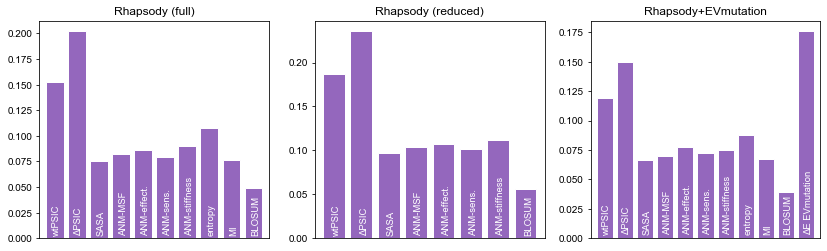

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, (version, d) in enumerate(RF_training_summaries.items()):
    
    featset = rd.DEFAULT_FEATSETS[version]
    n = len(featset)

    ax = axes[i]
    ax.set_title(abbrv[version])
    
    # bar plots
    x = np.arange(n)
    y = d['no stratification']['feat. importances'][0]
    ax.bar(x, y, color='C4', width=.8, edgecolor='w')

    ax.set_xlim((-.7, n-0.3))
    
    ax.set_xticks([])
    labels = [abbrv[f] for f in rd.DEFAULT_FEATSETS[version]]
    ax.set_xticklabels(labels, rotation='vertical')
    
    for i,s in enumerate([abbrv[f] for f in featset]):
        ax.text(x[i]+.1, 0.003, s, color='w', rotation=90, ha='center', va='bottom', size='9.5')

fig.savefig('local/figures/feature_importances.png', dpi=300)

## Correlation between features

In [23]:
abbrv_2 = {
    'ANM_MSF-chain': 'MSF',
    'ANM_effectiveness-chain': 'eff',
    'ANM_sensitivity-chain': 'sens',
    'BLOSUM': 'BLSM',
    'Delta_PSIC': 'ΔPSIC', 
    'EVmut-DeltaE_epist': 'EVm.ΔE',
    'SASA': 'SASA',
    'entropy': 'entropy',
    'ranked_MI': 'MI',
    'stiffness-chain': 'stiff',
    'wt_PSIC': 'wtPSIC',
    'full': 'Rhapsody (full)',
    'reduced': 'Rhapsody (reduced)',
    'EVmut': 'Rhapsody+EVmutation',
}

In [24]:
from scipy.stats import spearmanr

featset = rd.DEFAULT_FEATSETS['EVmut']

X = ID[featset]
sel = [~np.isnan(np.sum([x for x in r])) for r in X]
X = X[sel]
X = np.array([[np.float32(x) for x in v] for v in X])

correlations = spearmanr(X)

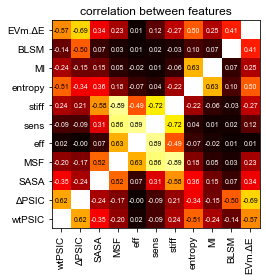

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
m = correlations[0]

im = ax.imshow(abs(m), cmap='hot', vmin=0, vmax=1)
ax.set_title('correlation between features')

# text annotations
n = m.shape[0]
for i in range(n):
    for j in range(n):
        if i==j: continue
        text = ax.text(j, i, f'{m[i, j]:.2f}', ha="center", va="center", 
                       color="w" if abs(m[i, j])<.5 else "k", fontsize='x-small')

labels = [abbrv_2[f] for f in rd.DEFAULT_FEATSETS['EVmut']]
ax.set_yticks(range(n))
ax.set_yticklabels(labels)
ax.set_ylim((-.5, 10.5))
ax.set_xticks(range(n))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_xlim((-.5, 10.5))

fig.tight_layout()
fig.savefig('local/figures/correlation_btw_features.png', dpi=300)

## Feature distributions

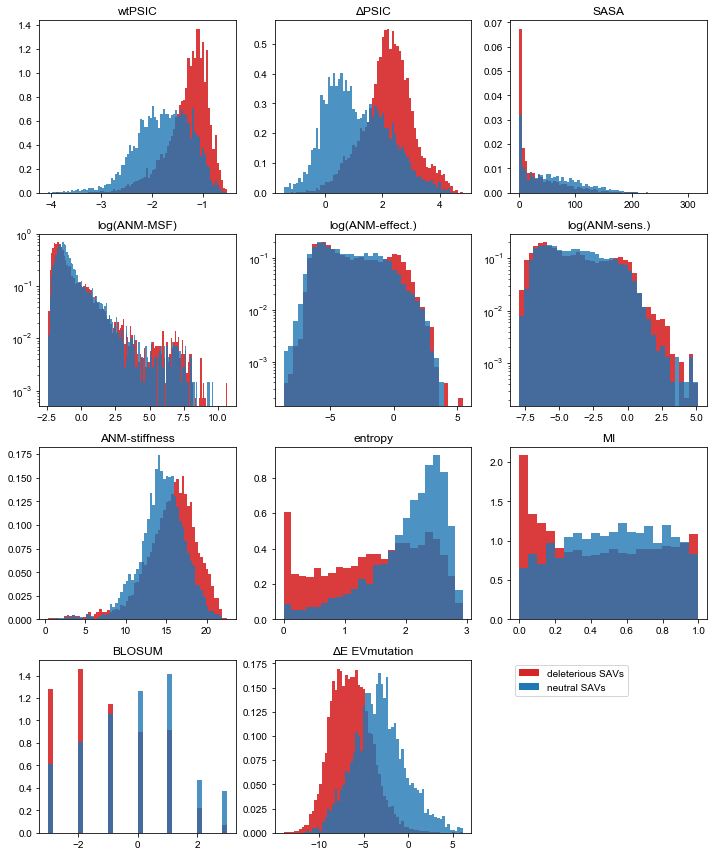

In [26]:
from matplotlib.patches import Patch

fig, axes = plt.subplots(4, 3, figsize=(10, 12))

classes = {
    'del' : ID[ID['true_label']==1],
    'neu' : ID[ID['true_label']==0]
}

for n, feature in enumerate(rd.DEFAULT_FEATSETS['EVmut']):
    
    ax = axes[int(n/3), n%3]
    
    data = {}
    for cl in ('del', 'neu'):
        d = classes[cl][feature]
        data[cl] = d[~np.isnan(d)]

    title = abbrv[feature]

    if feature.startswith('ANM'):
        # use log-log scale
        title = f'log({title})'
        ax.set_yscale('log')
        for k in data:
            data[k] = np.log(data[k])
 
    ax.set_title(title)
    
    n, bins, patches = ax.hist(data['del'], bins='fd', color='C3', alpha=.9, density=True)
    ax.hist(data['neu'], bins=bins, color='C0', alpha=.8, density=True)

axes[3,2].axis('off')
legend_elements = [Patch(facecolor='C3', label='deleterious SAVs'), 
                   Patch(facecolor='C0', label='neutral SAVs')]
axes[3,2].legend(handles=legend_elements, loc='upper left')
        
fig.tight_layout()
fig.savefig('local/figures/feat_distributions.png', dpi=300)

In [27]:
plt.rcParams.update(plt.rcParamsDefault)